In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import model.graph_adj_x_diffusion as graph_adj_x_diffusion
import model.graph_net as graph_net
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import rdkit
import IPython
import importlib

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 1]
branch_defs = [((0, 1), 0.5, 1), ((0,), 0, 0.5), ((1,), 0, 0.5)]

# branch_defs = [((0, 1), 0.3, 1), ((0,), 0, 0.3), ((1,), 0, 0.3)]

# branch_defs = [((0, 1), 0.15, 1), ((0,), 0, 0.15), ((1,), 0, 0.15)]

In [4]:
dataset = molecule_dataset.ZINCDataset(label_method="num_cycles", nums_to_label=[0, 1])

# Limit classes
inds = np.isin(dataset.target, classes)
dataset.all_smiles = dataset.all_smiles[inds]
dataset.target = dataset.target[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
# Create the SDE and model
sde = graph_adj_x_diffusion.AXJointSDE(0.1, 1, 0.2, 1, input_shape)

t_limit = 1

model = graph_net.GraphJointNetwork(len(branch_defs), t_limit).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_cycle_0_1"
importlib.reload(graph_adj_x_diffusion)

<module 'model.graph_adj_x_diffusion' from '/gstore/home/tsenga5/branched_diffusion/notebooks/../src/model/graph_adj_x_diffusion.py'>

### Show the forward-diffusion process

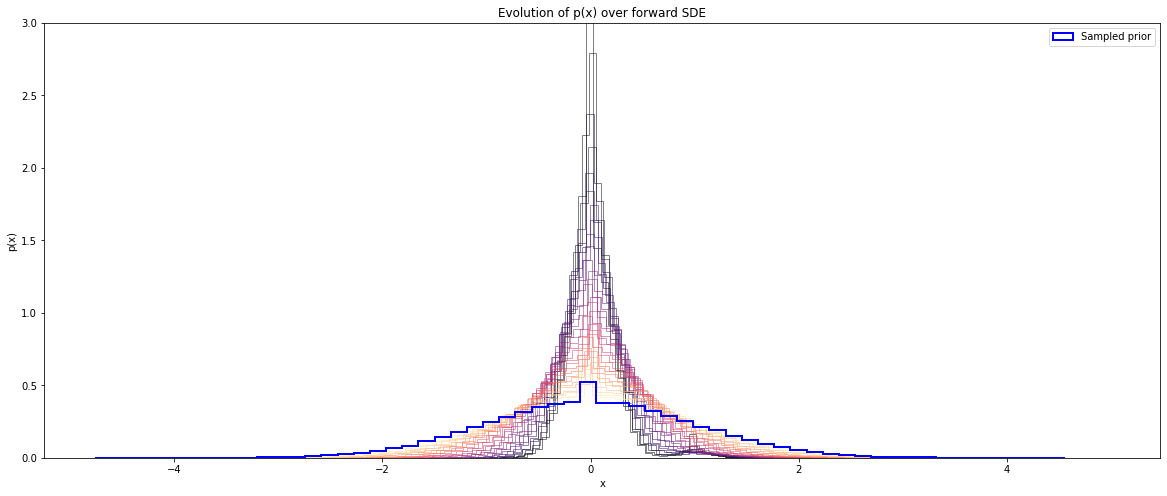

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
# import model.util as model_util
# model = model_util.load_model(
#     graph_net.GraphJointNetwork,
#     "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/zinc250k_continuous_cycle_0_1/1/last_ckpt.pth"
# ).to(DEVICE)

In [9]:
graph_adj_x_diffusion.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 200,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "3"
Loss: 436.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [02:34<00:00,  1.10it/s]


Epoch 1 average Loss: 850.88


Loss: 410.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [02:34<00:00,  1.10it/s]


Epoch 2 average Loss: 428.49


Loss: 418.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [02:34<00:00,  1.10it/s]


Epoch 3 average Loss: 386.50


Loss: 279.04: 100%|██████████████████████████████████████████| 170/170 [02:32<00:00,  1.12it/s]


Epoch 4 average Loss: 360.08


Loss: 447.62: 100%|██████████████████████████████████████████| 170/170 [02:30<00:00,  1.13it/s]


Epoch 5 average Loss: 349.83


Loss: 360.51: 100%|██████████████████████████████████████████| 170/170 [02:30<00:00,  1.13it/s]


Epoch 6 average Loss: 340.85


Loss: 373.52: 100%|██████████████████████████████████████████| 170/170 [02:29<00:00,  1.14it/s]


Epoch 7 average Loss: 331.50


Loss: 309.51: 100%|██████████████████████████████████████████| 170/170 [02:29<00:00,  1.14it/s]


Epoch 8 average Loss: 323.08


Loss: 262.00: 100%|██████████████████████████████████████████| 170/170 [02:29<00:00,  1.14it/s]


Epoch 9 average Loss: 316.60


Loss: 343.95: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 10 average Loss: 310.96


Loss: 337.45: 100%|██████████████████████████████████████████| 170/170 [02:28<00:00,  1.14it/s]


Epoch 11 average Loss: 306.17


Loss: 283.71:  62%|██████████████████████████▏               | 106/170 [01:32<00:55,  1.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 218.96: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 21 average Loss: 266.22


Loss: 243.19: 100%|█████████████████████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 22 average Loss: 263.39


Loss: 264.24: 100%|█████████████████████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 23 average Loss: 261.56


Loss: 254.83: 100%|█████████████████████████████████████████████████████████| 170/170 [02:22<00:00,  1.20it/s]


Epoch 24 average Loss: 257.61


Loss: 301.15: 100%|█████████████████████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 25 average Loss: 256.79


Loss: 309.44: 100%|█████████████████████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 26 average Loss: 255.74


Loss: 213.62: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 27 average Loss: 251.90


Loss: 265.07: 100%|█████████████████████████████████████████████████████████| 170/170 [02:44<00:00,  1.03it/s]


Epoch 28 average Loss: 248.34


Loss: 253.92: 100%|█████████████████████████████████████████████████████████| 170/170 [02:54<00:00,  1.03s/it]


Epoch 29 average Loss: 248.50


Loss: 273.15: 100%|█████████████████████████████████████████████████████████| 170/170 [03:16<00:00,  1.16s/it]


Epoch 30 average Loss: 246.81


Loss: 218.67: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 31 average Loss: 246.10


Loss: 327.41: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 32 average Loss: 244.04


Loss: 242.27: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 33 average Loss: 243.20


Loss: 285.02: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 34 average Loss: 244.41


Loss: 223.98: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 35 average Loss: 242.68


Loss: 246.73: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 36 average Loss: 240.05


Loss: 284.11: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 37 average Loss: 238.44


Loss: 217.63: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.18it/s]


Epoch 38 average Loss: 241.23


Loss: 211.18: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 39 average Loss: 235.82


Loss: 209.56: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 40 average Loss: 236.56


Loss: 234.81: 100%|█████████████████████████████████████████████████████████| 170/170 [02:53<00:00,  1.02s/it]


Epoch 41 average Loss: 236.00


Loss: 231.25: 100%|█████████████████████████████████████████████████████████| 170/170 [02:45<00:00,  1.02it/s]


Epoch 42 average Loss: 234.57


Loss: 227.93: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 43 average Loss: 235.76


Loss: 196.43: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 44 average Loss: 236.25


Loss: 245.12: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 45 average Loss: 235.77


Loss: 192.17: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 46 average Loss: 233.54


Loss: 208.92: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 47 average Loss: 233.22


Loss: 183.59: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 48 average Loss: 231.18


Loss: 228.54: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 49 average Loss: 230.94


Loss: 321.48: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 50 average Loss: 232.89


Loss: 287.80: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 51 average Loss: 231.75


Loss: 258.41: 100%|█████████████████████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 52 average Loss: 232.38


Loss: 206.02: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 53 average Loss: 231.80


Loss: 280.22: 100%|█████████████████████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 54 average Loss: 229.51


Loss: 276.00: 100%|██████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]00:57<01:28,  1.16it/s]


Epoch 57 average Loss: 230.46


Loss: 292.31: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 58 average Loss: 228.15


Loss: 277.39: 100%|██████████████████████████████████████████| 170/170 [02:24<00:00,  1.17it/s]


Epoch 59 average Loss: 229.89


Loss: 212.02: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 60 average Loss: 228.86


Loss: 225.90: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 61 average Loss: 227.61


Loss: 242.07: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 62 average Loss: 226.45


Loss: 236.43: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 63 average Loss: 229.24


Loss: 244.31: 100%|██████████████████████████████████████████| 170/170 [02:25<00:00,  1.17it/s]


Epoch 64 average Loss: 228.72


Loss: 222.31:  82%|██████████████████████████████████▌       | 140/170 [02:00<00:25,  1.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 204.68: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 84 average Loss: 224.56


Loss: 230.60: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.20it/s]


Epoch 85 average Loss: 223.42


Loss: 201.15: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 86 average Loss: 222.66


Loss: 194.06: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 87 average Loss: 221.38


Loss: 257.55: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 88 average Loss: 223.19


Loss: 203.51: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 89 average Loss: 220.48


Loss: 207.55: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.20it/s]


Epoch 90 average Loss: 222.58


Loss: 213.75: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 91 average Loss: 221.18


Loss: 222.56:  89%|█████████████████████████████████████▌    | 152/170 [02:07<00:15,  1.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 168.97: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 111 average Loss: 217.03


Loss: 222.02: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 112 average Loss: 216.63


Loss: 212.14: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 113 average Loss: 218.69


Loss: 242.93: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 114 average Loss: 216.53


Loss: 226.38: 100%|██████████████████████████████████████████| 170/170 [02:26<00:00,  1.16it/s]


Epoch 115 average Loss: 216.98


Loss: 188.17: 100%|██████████████████████████████████████████| 170/170 [02:28<00:00,  1.14it/s]


Epoch 116 average Loss: 218.65


Loss: 209.17: 100%|██████████████████████████████████████████| 170/170 [02:28<00:00,  1.15it/s]


Epoch 117 average Loss: 217.55


Loss: 228.31: 100%|██████████████████████████████████████████| 170/170 [02:27<00:00,  1.15it/s]


Epoch 118 average Loss: 216.76


Loss: 204.29: 100%|██████████████████████████████████████████| 170/170 [02:28<00:00,  1.15it/s]


Epoch 119 average Loss: 217.83


Loss: 210.61:  21%|████████▊                                  | 35/170 [00:30<01:57,  1.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 243.32: 100%|██████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 139 average Loss: 215.56


Loss: 296.64: 100%|██████████████████████████████████████████| 170/170 [02:24<00:00,  1.18it/s]


Epoch 140 average Loss: 215.23


Loss: 197.07: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 141 average Loss: 213.65


Loss: 206.93: 100%|██████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 142 average Loss: 215.24


Loss: 205.05: 100%|██████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 143 average Loss: 214.08


Loss: 202.04: 100%|██████████████████████████████████████████| 170/170 [02:23<00:00,  1.18it/s]


Epoch 144 average Loss: 213.84


Loss: 261.45: 100%|█████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 145 average Loss: 214.09


Loss: 240.12: 100%|█████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 146 average Loss: 213.63


Loss: 268.70: 100%|█████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 147 average Loss: 214.31


Loss: 291.57: 100%|█████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 148 average Loss: 212.42


Loss: 230.45: 100%|█████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 149 average Loss: 212.46


Loss: 240.83: 100%|█████████████████████████████████████████████████████████| 170/170 [02:22<00:00,  1.19it/s]


Epoch 150 average Loss: 213.44


Loss: 273.69: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 152 average Loss: 213.98


Loss: 235.33: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 153 average Loss: 211.97


Loss: 301.80: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 154 average Loss: 214.30


Loss: 230.09: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 155 average Loss: 211.81


Loss: 275.08: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 156 average Loss: 213.36


Loss: 192.99: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.18it/s]


Epoch 157 average Loss: 212.36


Loss: 267.10: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 158 average Loss: 212.69


Loss: 239.61: 100%|████████████████████████████████████████████████████████████████| 170/170 [02:23<00:00,  1.19it/s]


Epoch 159 average Loss: 212.10


Loss: 203.51:  89%|█████████████████████████████████████████████████████████▏      | 152/170 [02:08<00:15,  1.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Show generated distributions

In [11]:
samples = {}
num_samples_per_class = 32
for class_to_sample in classes:
    # Sample some initial node flags
    inds = np.random.choice(np.where(dataset.target == class_to_sample)[0], size=num_samples_per_class, replace=True)
    batch = torch.stack([dataset[i][0] for i in inds], dim=0)
    adj = batch[:, :, :batch.shape[1]]
    sampled_flags = graph_net.node_flags(adj)
    
    sample = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampled_flags, num_samples=num_samples_per_class, t_limit=t_limit,
        num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.36it/s]


In [12]:
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]
BOND_TYPES = [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE]

def samples_to_adj_x(samps):
    """
    Given a B x M x (M + D) array of adjacency matrices and node features,
    discretizes them and returns the adjacency matrices (B x M x M) and
    node features (B x M x D),
    """
    s = samps.shape[1]
    adj, x = samps[:, :, :s], samps[:, :, s:]
    
    # Discretize
    adj[adj < 0.5] = 0
    adj[(adj >= 0.5) & (adj < 1.5)] = 1
    adj[(adj >= 1.5) & (adj < 2.5)] = 2
    adj[adj >= 2.5] = 3
    adj = np.triu(adj, k=1)
    adj = adj + np.swapaxes(adj, 1, 2)
    x[x < 0.5] = 0
    x[x >= 0.5] = 1
    adj, x = adj.astype(int), x.astype(int)
    return adj, x

def samples_to_rdkmols(adj, x, flags):
    """
    Given a B x M x M adjacency matrix batch and B x M x D node feature
    batch, and a B x M binary array of flags (all NumPy arrays),
    converts them to RDKit molecule objects.
    """
    mol_sizes = np.sum(flags, axis=1)
    atomic_nums = np.argmax(x, axis=2)
    
    mols = []
    for i in range(len(adj)):
        size = mol_sizes[i]
        a, atoms = adj[i][:size][:, :size], atomic_nums[i][:size]
        mol = rdkit.Chem.RWMol()
        
        for atom in atoms:
            mol.AddAtom(rdkit.Chem.Atom(ATOM_SYMBOLS[atom]))
            
        for u, v in zip(*np.nonzero(np.triu(a, k=1))):
            mol.AddBond(int(u), int(v), BOND_TYPES[a[u, v] - 1])
        
        mol.UpdatePropertyCache(strict=False)  # Set valences
        
        mols.append(mol)
    return mols

def plot_molecule(mol):
    mc = rdkit.Chem.Mol(mol.ToBinary())
    rdkit.Chem.Kekulize(mc)
    
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(450, 150)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return IPython.display.SVG(svg.replace("svg:",""))

In [13]:
# Convert to molecule objects
mol_samples = {}
for class_to_sample in classes:
    samps = samples[class_to_sample]
    
    # Separate and discretize
    adj, x = samples_to_adj_x(samps)
    
    # Convert
    mol_samples[class_to_sample] = samples_to_rdkmols(adj, x, sampled_flags.cpu().numpy().astype(int))

0


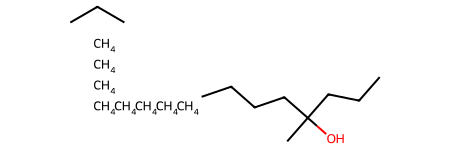

C.C.C.C.C.C.C.C.CCC.CCCCC(C)(O)CCC


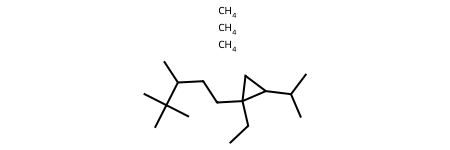

C.C.C.CCC1(CCC(C)C(C)(C)C)CC1C(C)C


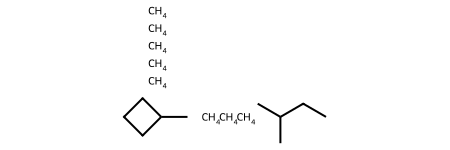

C.C.C.C.C.C.C.C.CC1CCC1.CCC(C)C


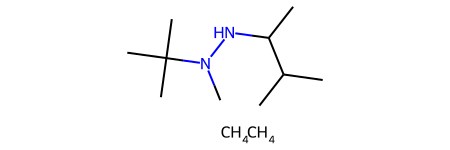

C.C.CC(C)C(C)NN(C)C(C)(C)C


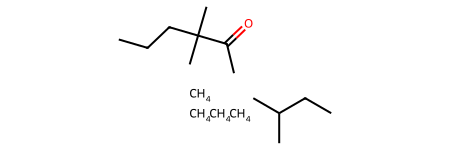

C.C.C.C.CCC(C)C.CCCC(C)(C)C(C)=O


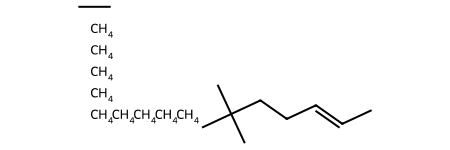

C.C.C.C.C.C.C.C.C.CC.CC=CCCC(C)(C)C


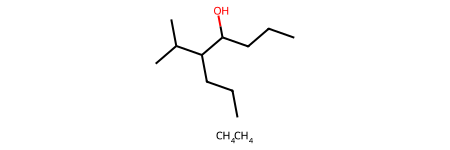

C.C.CCCC(O)C(CCC)C(C)C


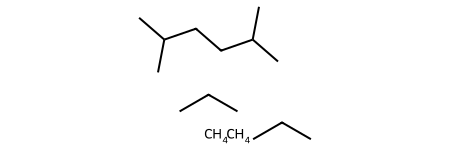

C.C.CC(C)CCC(C)C.CCC.CCC


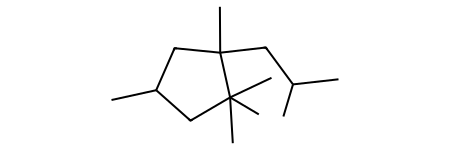

CC(C)CC1(C)CC(C)CC1(C)(C)C


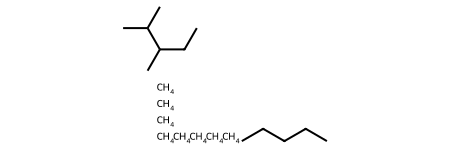

C.C.C.C.C.C.C.C.CCC(C)C(C)C.CCCCC


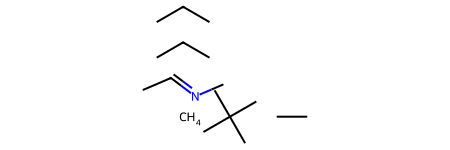

C.CC.CC(C)(C)C.CC=NC.CCC.CCC


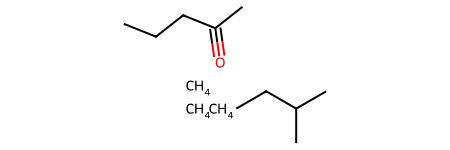

C.C.C.CCC(C)C.CCCC(C)#O


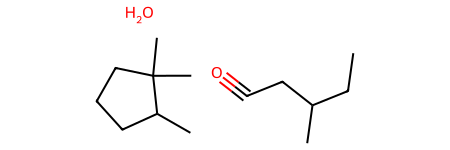

CC1CCCC1(C)C.CCC(C)CC#O.O


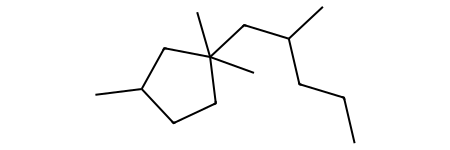

CCCC(C)CC1(C)(C)CCC(C)C1


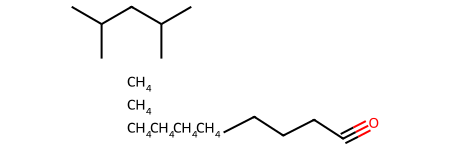

C.C.C.C.C.C.CC(C)CC(C)C.CCCCC#O


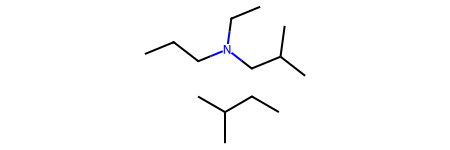

CCC(C)C.CCCN(CC)CC(C)C


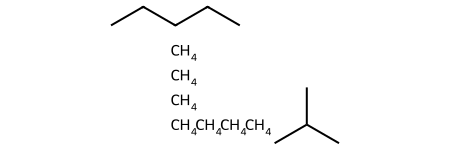

C.C.C.C.C.C.C.CC(C)C.CCCCC


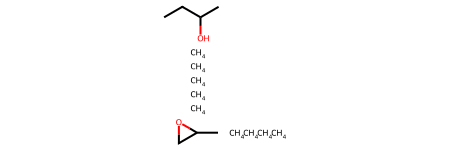

C.C.C.C.C.C.C.C.C.CC1CO1.CCC(C)O


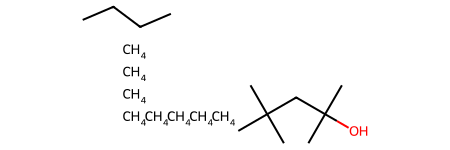

C.C.C.C.C.C.C.C.CC(C)(C)CC(C)(C)O.CCCC


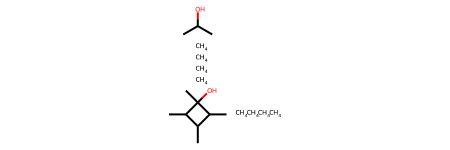

C.C.C.C.C.C.C.C.CC(C)O.CC1C(C)C(C)(O)C1C


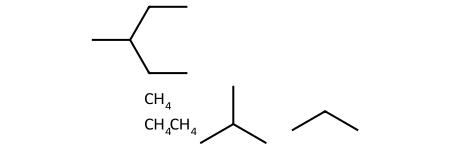

C.C.C.CC(C)C.CCC.CCC(C)CC


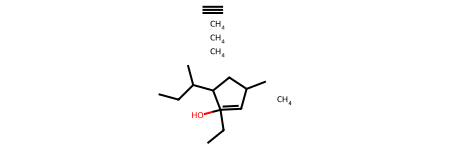

C.C.C.C.C#C.CCC(C)C1CC(C)C=C1(O)CC


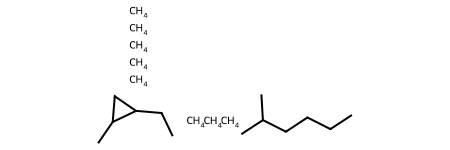

C.C.C.C.C.C.C.C.CCC1CC1C.CCCCC(C)C


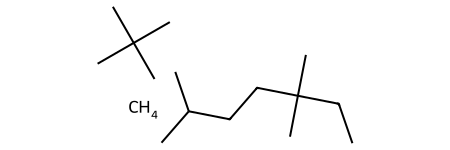

C.CC(C)(C)C.CCC(C)(C)CCC(C)C


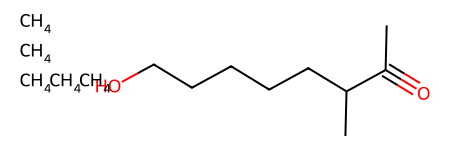

C.C.C.C.C.CC(#O)C(C)CCCCCO


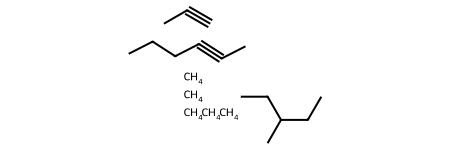

C.C.C.C.C.C#CC.CC#CCCC.CCC(C)CC


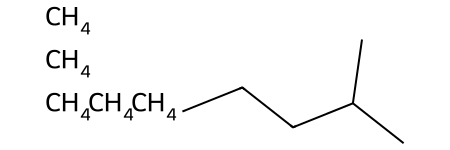

C.C.C.C.C.CCCC(C)C


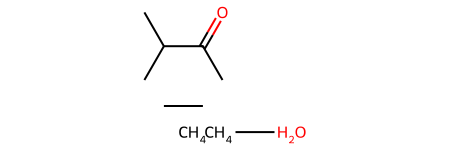

C.C.CC.CC.CC(=O)C(C)C.O


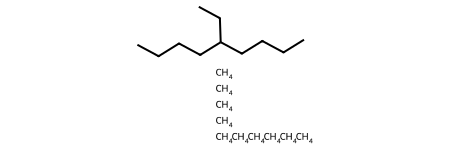

C.C.C.C.C.C.C.C.C.C.CCCCC(CC)CCCC


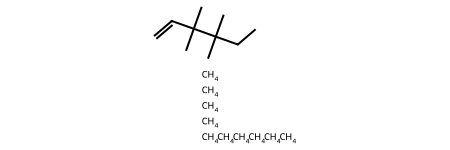

C.C.C.C.C.C.C.C.C.C.C=CC(C)(C)C(C)(C)CC


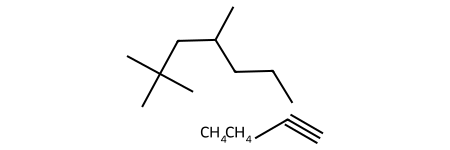

C.C.C#CC.CCCC(C)CC(C)(C)C


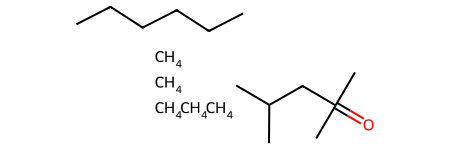

C.C.C.C.C.CC(C)CC(C)(C)=O.CCCCCC
1


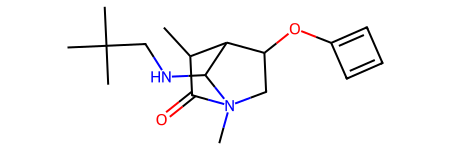

CC1C(=O)N2(C)CC(OC3=CC=C3)C1C2NCC(C)(C)C


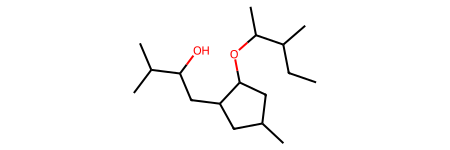

CCC(C)C(C)OC1CC(C)CC1CC(O)C(C)C


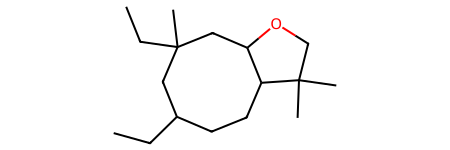

CCC1CCC2C(CC(C)(CC)C1)OCC2(C)C


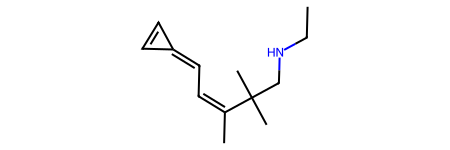

CCNCC(C)(C)C(C)=CC=C1C=C1


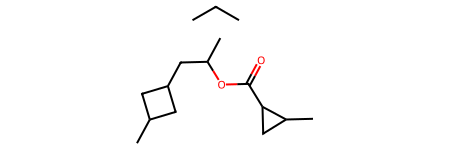

CC1CC(CC(C)OC(=O)C2CC2C)C1.CCC


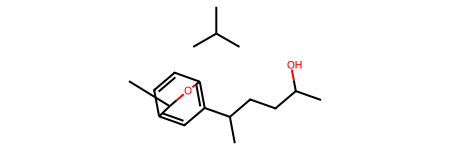

CC(C)C.CC(O)CCC(C)C1=C2C=CC(=C1)C(C)O2


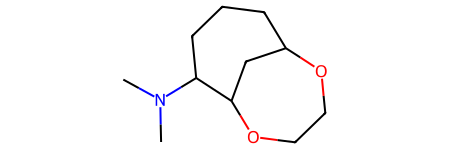

CN(C)C1CCCC2CC1OCCO2


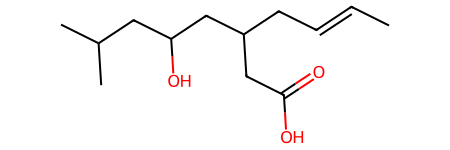

CC=CCC(CC(=O)O)CC(O)CC(C)C


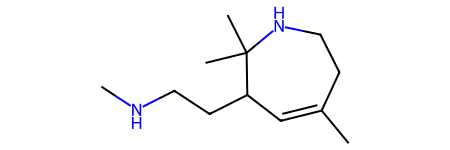

CNCCC1C=C(C)CCNC1(C)C


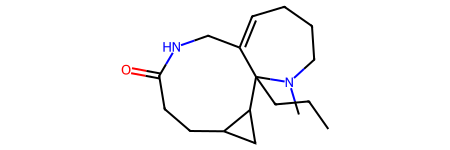

CCCC12C(=CCCCN1C)CNC(=O)CCC1CC12


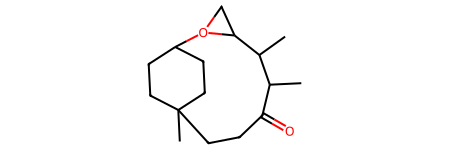

CC1C(=O)CCC2(C)CCC(CC2)O2CC2C1C


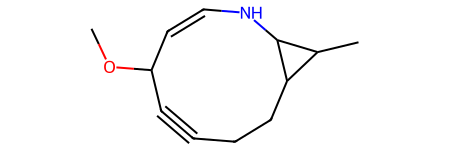

COC1C#CCCC2C(C)C2NC=C1


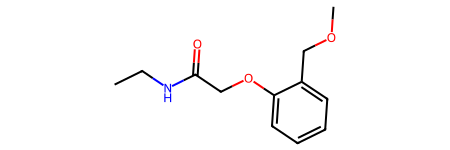

CCNC(=O)COC1=CC=CC=C1COC


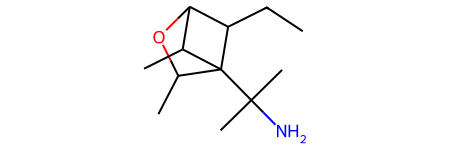

CCC1C2OC(C)C1(C(C)(C)N)C2C


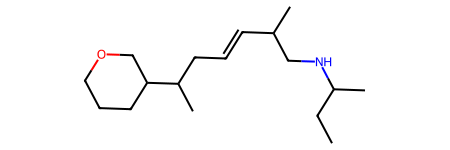

CCC(C)NCC(C)C=CCC(C)C1CCCOC1


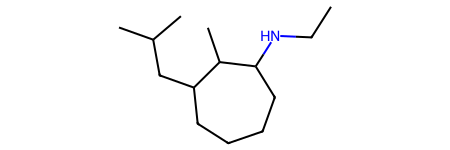

CCNC1CCCCC(CC(C)C)C1C


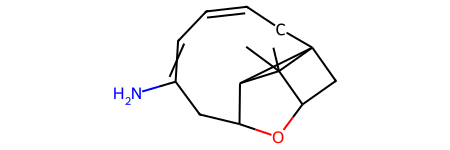

CC12(C)C3CC14CC=CC=C(N)CC(O3)C42


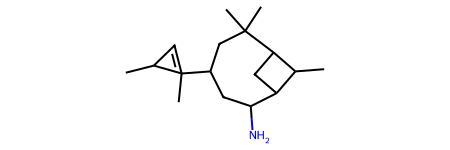

CC1C2CC1C(C)(C)CC(C1(C)=CC1C)CC2N


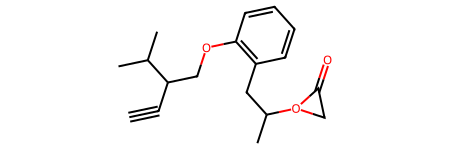

C#CC(COC1=C(CC(C)O2CC2=O)C=CC=C1)C(C)C


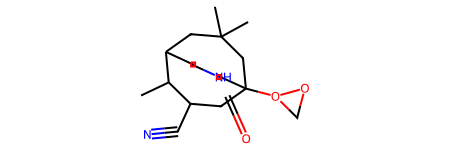

CC1C(C#N)CC2(O3CO3)CC(C)(C)CC1CCNC2=O


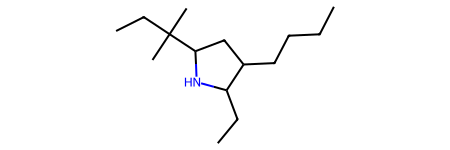

CCCCC1CC(C(C)(C)CC)NC1CC


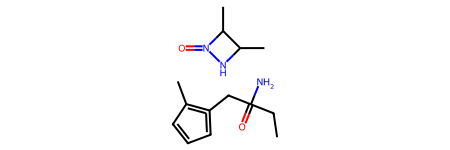

CC1NN(=O)C1C.CCC(N)(=O)CC1=CC=CC=1C


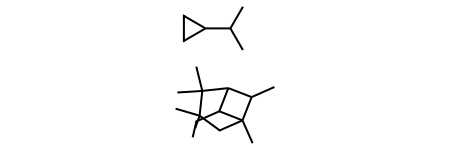

CC(C)C1CC1.CCC1C2C(C)C1(C)CC(C)(C)C2(C)C


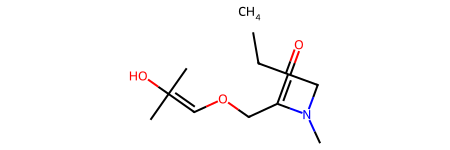

C.CCC1(=O)=C(COC=C(C)(C)O)N(C)C1


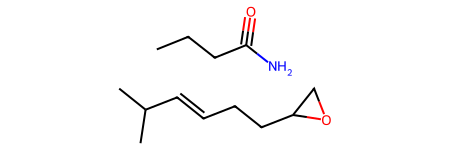

CC(C)C=CCCC1CO1.CCCC(N)#O


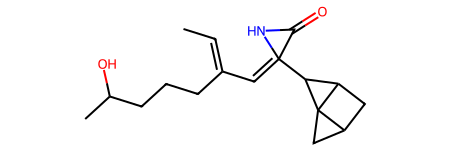

CC=C(C=C1(C2C3CC4CC432)NC1=O)CCCC(C)O


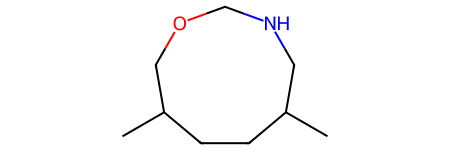

CC1CCC(C)COCNC1


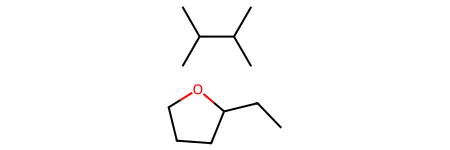

CC(C)C(C)C.CCC1CCCO1


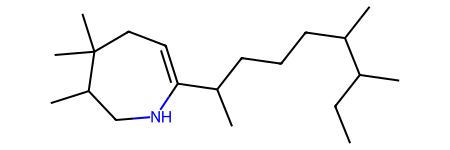

CCC(C)C(C)CCCC(C)C1=CCC(C)(C)C(C)CN1


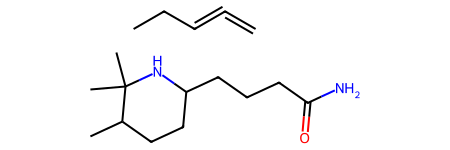

C=C=CCC.CC1CCC(CCCC(N)=O)NC1(C)C


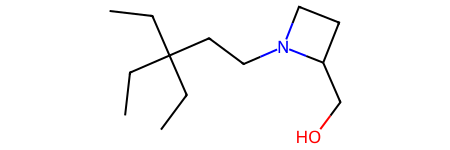

CCC(CC)(CC)CCN1CCC1CO


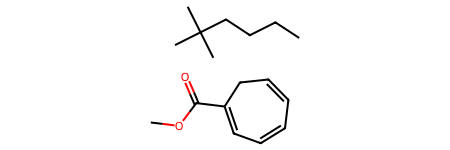

CCCCC(C)(C)C.COC(=O)C1=CC=CC=CC1


In [14]:
for class_to_sample in classes:
    print(class_to_sample)
    for mol in mol_samples[class_to_sample]:
        IPython.display.display(plot_molecule(mol))
        print(rdkit.Chem.MolToSmiles(mol))

### Transmutation

In [15]:
class_1, class_2 = 0, 1
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_2)[0], size=200, replace=False)
])
orig_1_adj = orig_1[:, :, :orig_1.shape[1]]
orig_1_flags = graph_net.node_flags(orig_1_adj)
orig_2_adj = orig_2[:, :, :orig_2.shape[1]]
orig_2_flags = graph_net.node_flags(orig_2_adj)

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
for t_i, t in enumerate(all_t):
    if t_i == 0:
        forward_1_to_2[t_i], forward_2_to_1[t_i] = orig_1.cpu().numpy(), orig_2.cpu().numpy()
    else:
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor,
        orig_1_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

    last_2_to_1 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor,
        orig_2_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

orig_1, orig_2 = orig_1.cpu().numpy(), orig_2.cpu().numpy()
before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]

In [16]:
# Convert to molecule objects
before_1_to_2_adj, before_1_to_2_x = samples_to_adj_x(before_1_to_2)
before_1_to_2_mols = samples_to_rdkmols(before_1_to_2_adj, before_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
after_1_to_2_adj, after_1_to_2_x = samples_to_adj_x(after_1_to_2)
after_1_to_2_mols = samples_to_rdkmols(after_1_to_2_adj, after_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
before_2_to_1_adj, before_2_to_1_x = samples_to_adj_x(before_2_to_1)
before_2_to_1_mols = samples_to_rdkmols(before_2_to_1_adj, before_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))
after_2_to_1_adj, after_2_to_1_x = samples_to_adj_x(after_2_to_1)
after_2_to_1_mols = samples_to_rdkmols(after_2_to_1_adj, after_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))

0 to 1
0


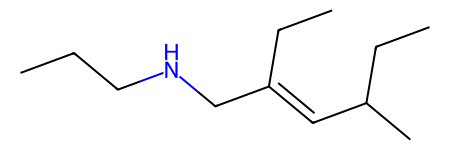

CCCNCC(=CC(C)CC)CC


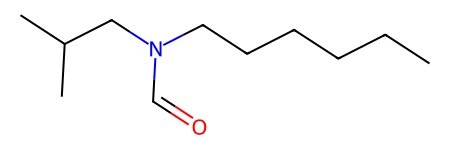

CCCCCCN(C=O)CC(C)C
1


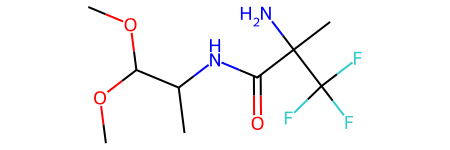

COC(OC)C(C)NC(=O)C(C)(N)C(F)(F)F


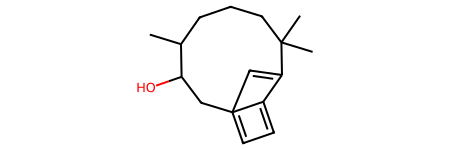

CC1CCCC(C)(C)C2=CC3(=CC=C23)CC1O
2


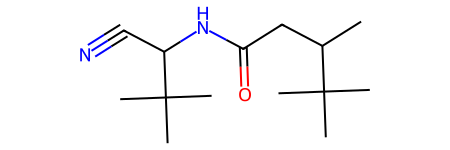

CC(CC(=O)NC(C#N)C(C)(C)C)C(C)(C)C


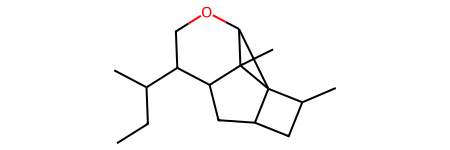

CCC(C)C1COC2C3(C)C1CC1CC(C)C123
3


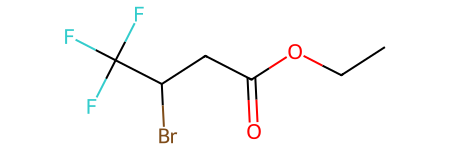

CCOC(=O)CC(Br)C(F)(F)F


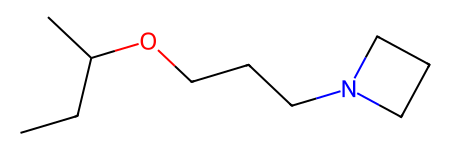

CCC(C)OCCCN1CCC1
4


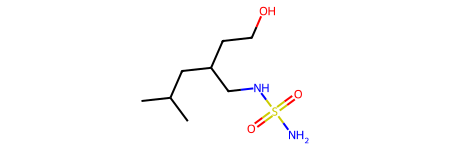

CC(C)CC(CCO)CNS(N)(=O)=O


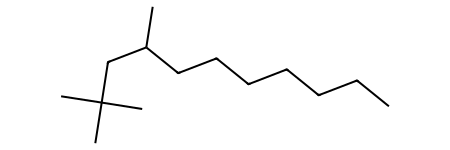

CCCCCCCC(C)CC(C)(C)C
5


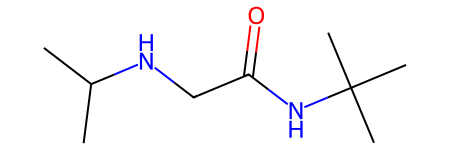

CC(C)NCC(=O)NC(C)(C)C


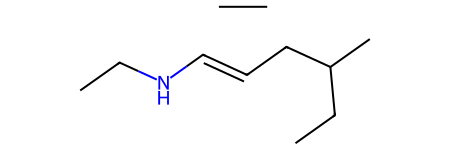

CC.CCNC=CCC(C)CC
6


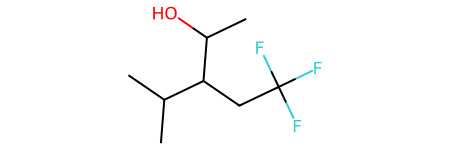

CC(C)C(CC(F)(F)F)C(C)O


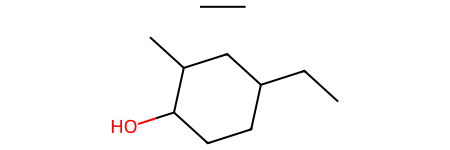

CC.CCC1CCC(O)C(C)C1
7


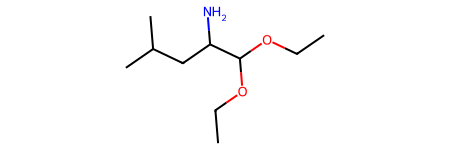

CCOC(OCC)C(N)CC(C)C


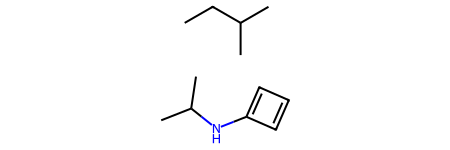

CC(C)NC1=CC=C1.CCC(C)C
8


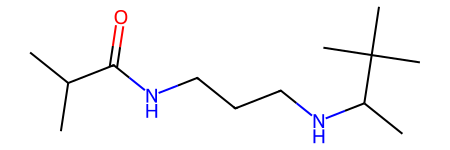

CC(C)C(=O)NCCCNC(C)C(C)(C)C


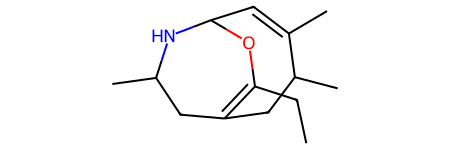

CCC1=C2CC(C)NC(C=C(C)C(C)C2)O1
9


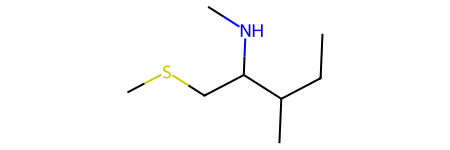

CCC(C)C(CSC)NC


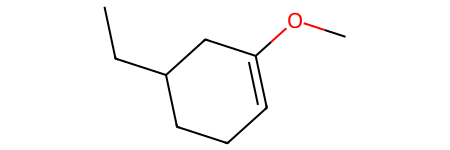

CCC1CCC=C(OC)C1
10


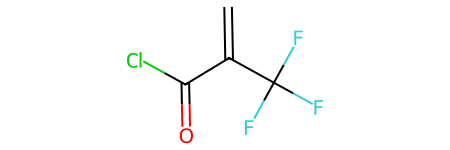

C=C(C(=O)Cl)C(F)(F)F


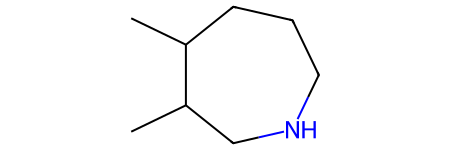

CC1CCCNCC1C
11


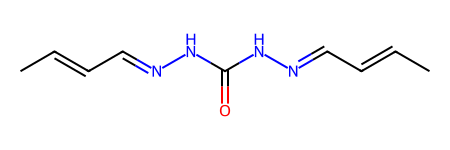

CC=CC=NNC(=O)NN=CC=CC


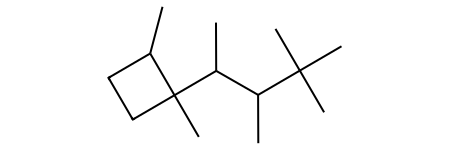

CC(C(C)C1(C)CCC1C)C(C)(C)C
12


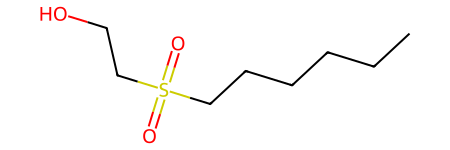

CCCCCCS(=O)(=O)CCO


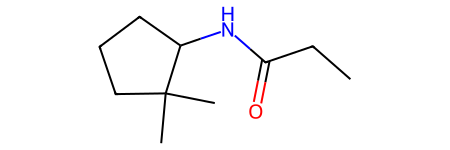

CCC(=O)NC1CCCC1(C)C
13


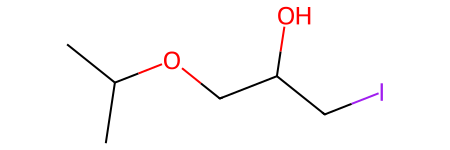

CC(C)OCC(O)CI


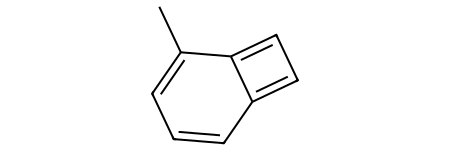

CC1=CC=CC2=CC=C12
14


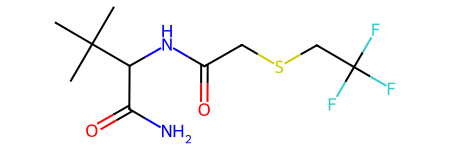

CC(C)(C)C(NC(=O)CSCC(F)(F)F)C(N)=O


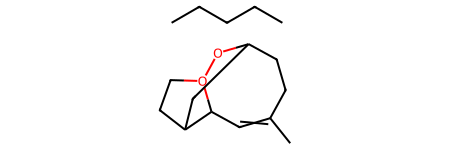

CC1=CC2C3CCO2OC(CC1)C3.CCCCC
15


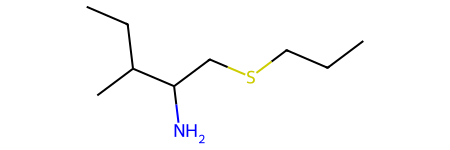

CCCSCC(N)C(C)CC


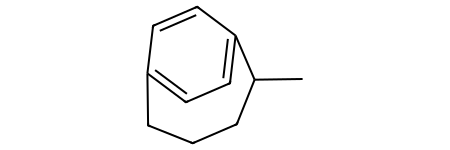

CC1CCCC2=CC=C1C=C2
16


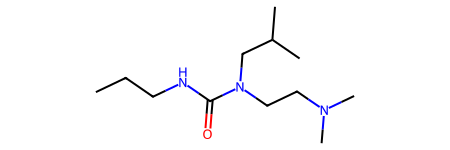

CCCNC(=O)N(CCN(C)C)CC(C)C


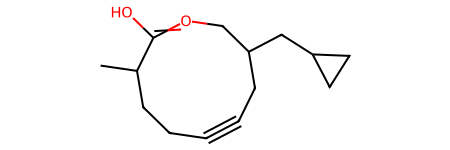

CC1CCC#CCC(CC2CC2)CO=C1O
17


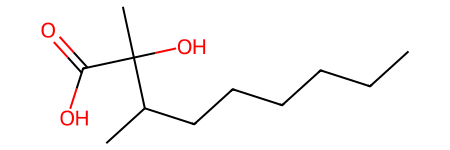

CCCCCCC(C)C(C)(O)C(=O)O


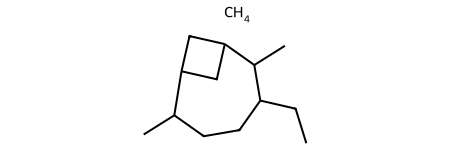

C.CCC1CCC(C)C2CC(C2)C1C
18


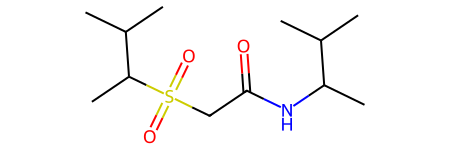

CC(C)C(C)NC(=O)CS(=O)(=O)C(C)C(C)C


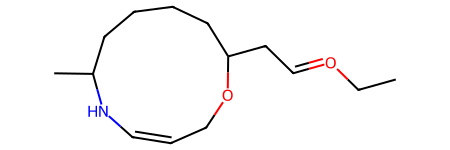

CCO=CCC1CCCCC(C)NC=CCO1
19


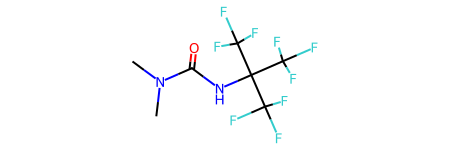

CN(C)C(=O)NC(C(F)(F)F)(C(F)(F)F)C(F)(F)F


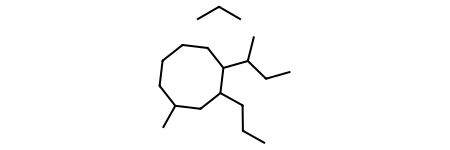

CCC.CCCC1CC(C)CCCCC1C(C)CC
20


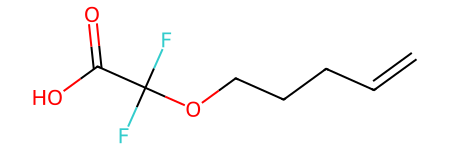

C=CCCCOC(F)(F)C(=O)O


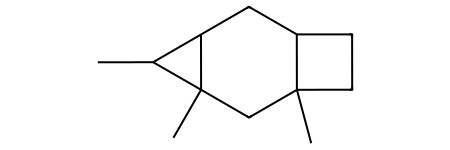

CC1C2CC3CCC3(C)CC12C
21


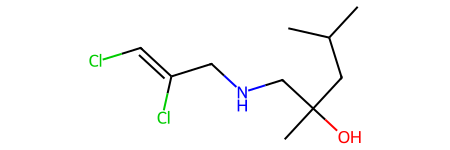

CC(C)CC(C)(O)CNCC(Cl)=CCl


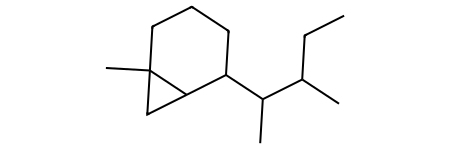

CCC(C)C(C)C1CCCC2(C)CC12
22


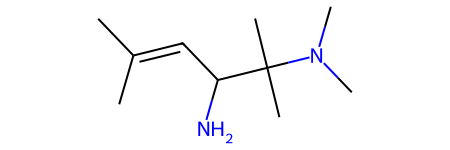

CC(C)=CC(N)C(C)(C)N(C)C


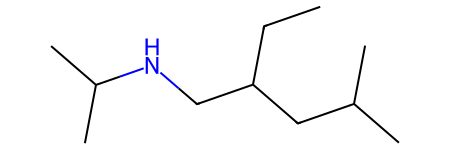

CCC(CNC(C)C)CC(C)C
23


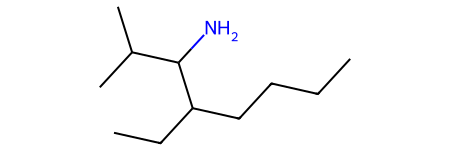

CCCCC(CC)C(N)C(C)C


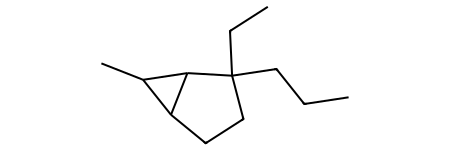

CCCC1(CC)CCC2C(C)C21
24


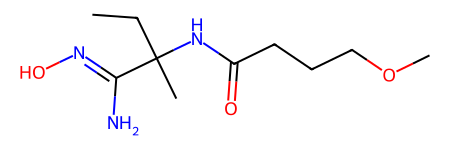

CCC(C)(NC(=O)CCCOC)C(N)=NO


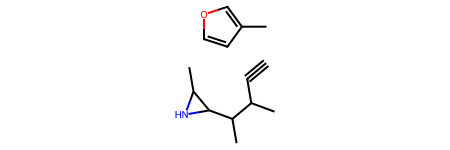

C#CC(C)C(C)C1NC1C.CC1=COC=C1
25


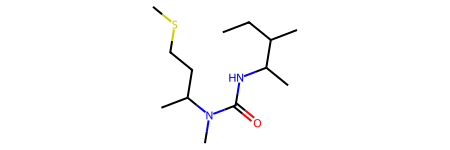

CCC(C)C(C)NC(=O)N(C)C(C)CCSC


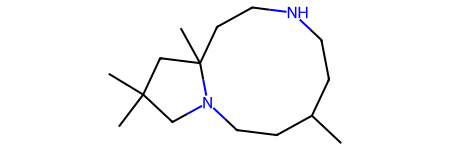

CC1CCNCCC2(C)CC(C)(C)CN2CC1
26


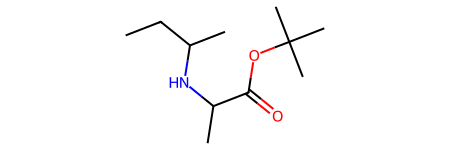

CCC(C)NC(C)C(=O)OC(C)(C)C


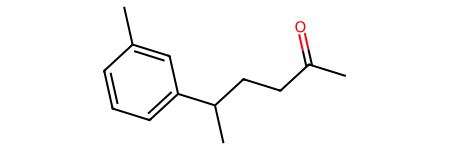

CC(=O)CCC(C)C1=CC=CC(C)=C1
27


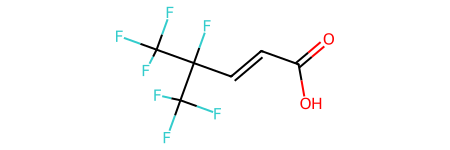

O=C(O)C=CC(F)(C(F)(F)F)C(F)(F)F


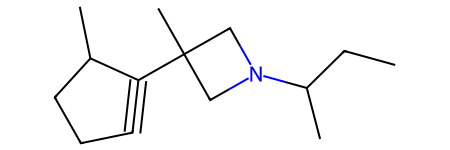

CCC(C)N1CC(C)(C2#CCCC2C)C1
28


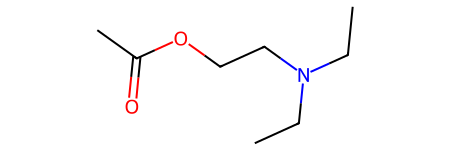

CCN(CC)CCOC(C)=O


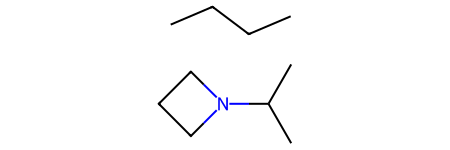

CC(C)N1CCC1.CCCC
29


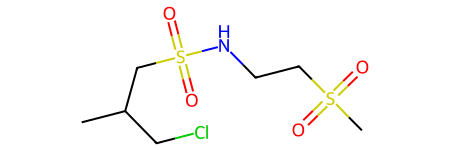

CC(CCl)CS(=O)(=O)NCCS(C)(=O)=O


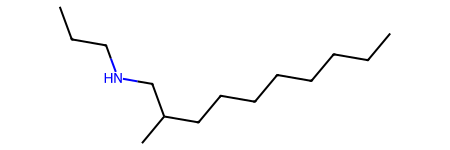

CCCCCCCCC(C)CNCCC
30


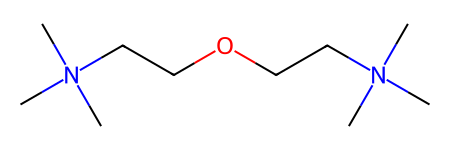

CN(C)(C)CCOCCN(C)(C)C


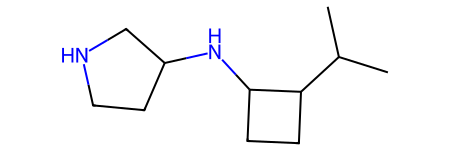

CC(C)C1CCC1NC1CCNC1
31


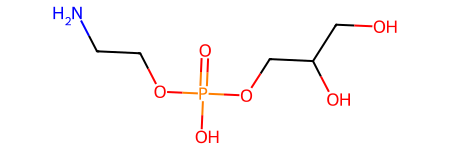

NCCOP(=O)(O)OCC(O)CO


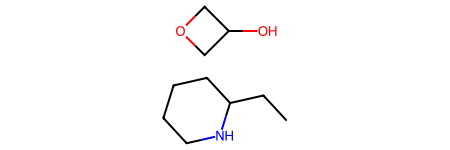

CCC1CCCCN1.OC1COC1
1 to 0
0


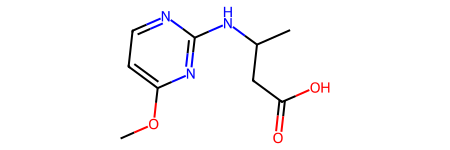

COC1=CC=NC(NC(C)CC(=O)O)=N1


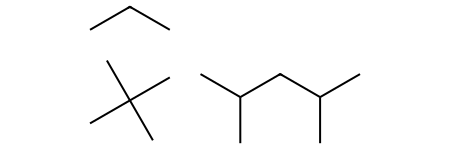

CC(C)(C)C.CC(C)CC(C)C.CCC
1


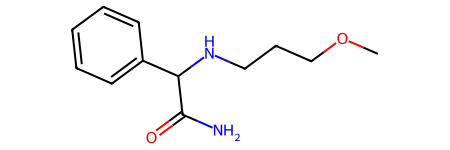

COCCCNC(C(N)=O)C1=CC=CC=C1


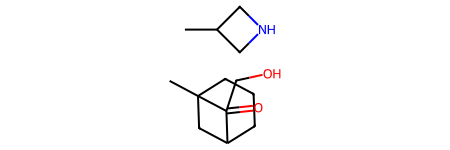

CC12CCCC(C1)C2(=O)CO.CC1CNC1
2


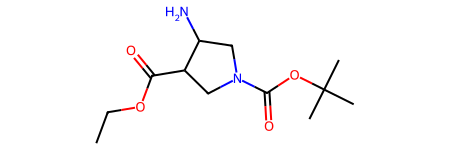

CCOC(=O)C1CN(C(=O)OC(C)(C)C)CC1N


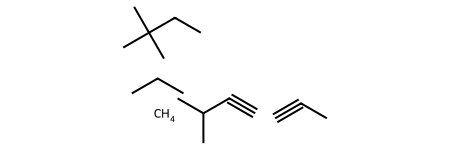

C.C#CC.C#CC(C)C.CCC.CCC(C)(C)C
3


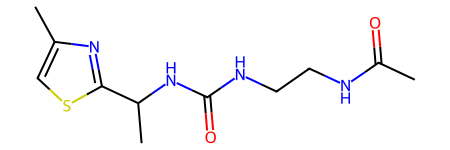

CC(=O)NCCNC(=O)NC(C)C1=NC(C)=CS1


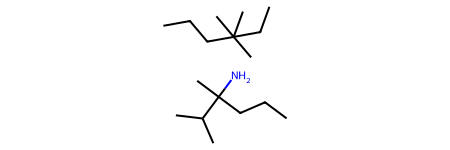

CCCC(C)(C)(C)CC.CCCC(C)(N)C(C)C
4


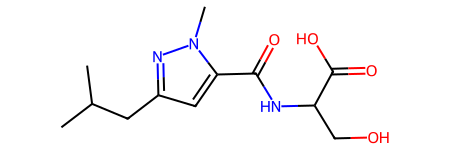

CC(C)CC1=NN(C)C(C(=O)NC(CO)C(=O)O)=C1


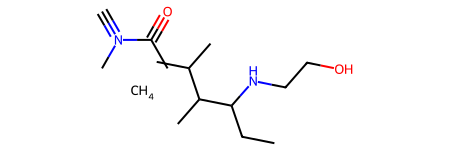

C.C#N(C)C(C)#O.CCC(NCCO)C(C)C(C)C
5


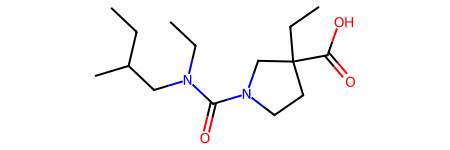

CCC(C)CN(CC)C(=O)N1CCC(CC)(C(=O)O)C1


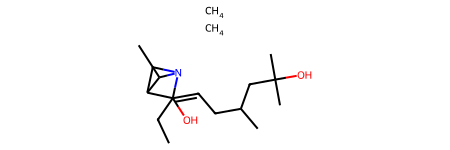

C.C.CCC1(O)(=CCC(C)CC(C)(C)O)C2CN1C2C
6


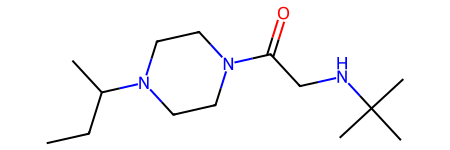

CCC(C)N1CCN(C(=O)CNC(C)(C)C)CC1


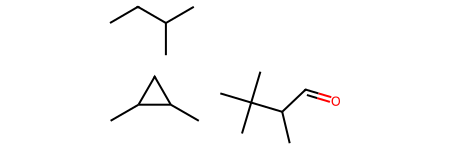

CC(C=O)C(C)(C)C.CC1CC1C.CCC(C)C
7


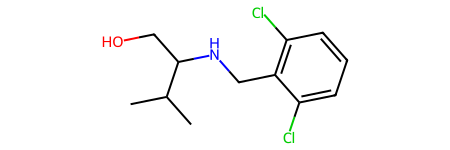

CC(C)C(CO)NCC1=C(Cl)C=CC=C1Cl


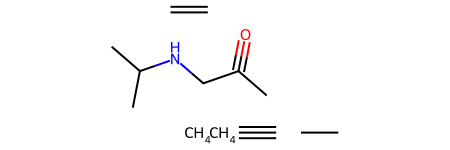

C.C.C#C.C=C.CC.CC(#O)CNC(C)C
8


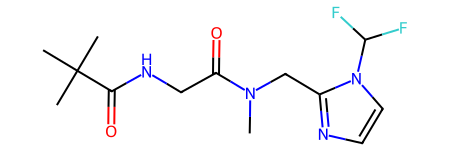

CN(CC1=NC=CN1C(F)F)C(=O)CNC(=O)C(C)(C)C


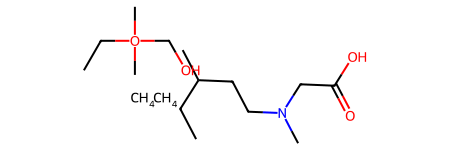

C.C.CCC(C)CCN(C)CC(=O)O.CCO(C)(C)CO
9


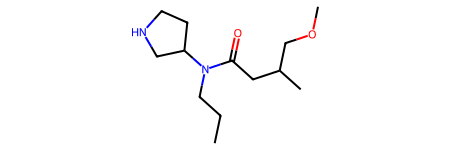

CCCN(C(=O)CC(C)COC)C1CCNC1


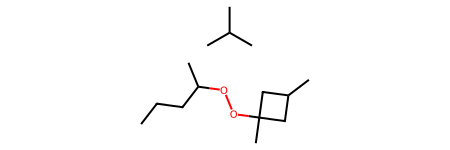

CC(C)C.CCCC(C)OOC1(C)CC(C)C1
10


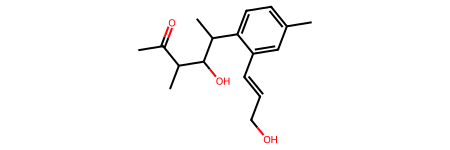

CC(=O)C(C)C(O)C(C)C1=CC=C(C)C=C1C=CCO


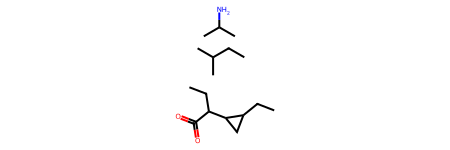

CC(C)N.CCC(C)C.CCC1CC1C(CC)C(=O)=O
11


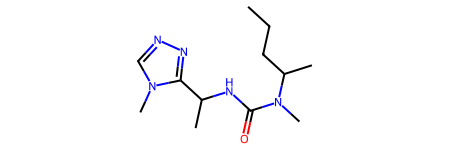

CCCC(C)N(C)C(=O)NC(C)C1=NN=CN1C


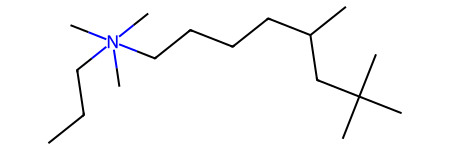

CCCN(C)(C)(C)CCCCC(C)CC(C)(C)C
12


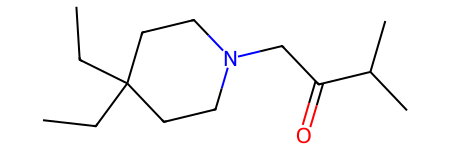

CCC1(CC)CCN(CC(=O)C(C)C)CC1


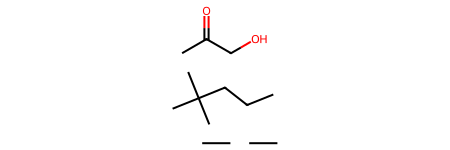

CC.CC.CC(=O)CO.CCCC(C)(C)C
13


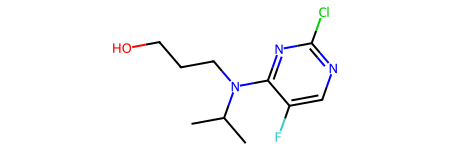

CC(C)N(CCCO)C1=NC(Cl)=NC=C1F


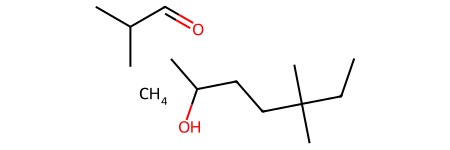

C.CC(C)C=O.CCC(C)(C)CCC(C)O
14


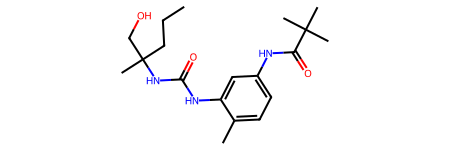

CCCC(C)(CO)NC(=O)NC1=CC(NC(=O)C(C)(C)C)=CC=C1C


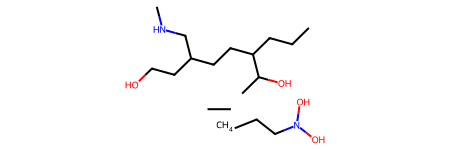

C.CC.CCCC(CCC(CCO)CNC)C(C)O.CCCN(O)O
15


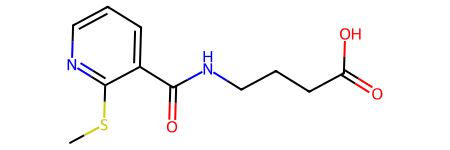

CSC1=NC=CC=C1C(=O)NCCCC(=O)O


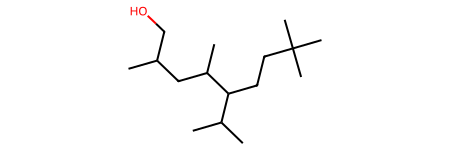

CC(CO)CC(C)C(CCC(C)(C)C)C(C)C
16


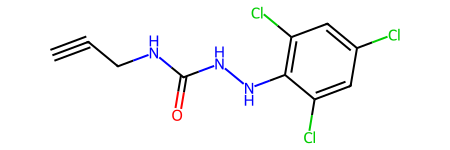

C#CCNC(=O)NNC1=C(Cl)C=C(Cl)C=C1Cl


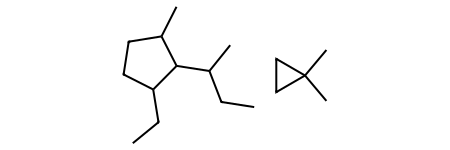

CC1(C)CC1.CCC(C)C1C(C)CCC1CC
17


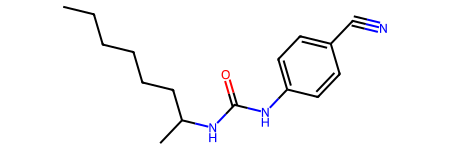

CCCCCCC(C)NC(=O)NC1=CC=C(C#N)C=C1


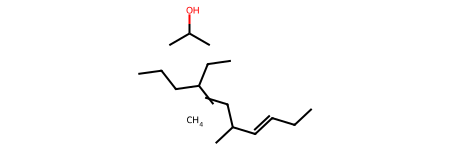

C.CC(C)O.CCC=CC(C)CC.CCCC(C)CC
18


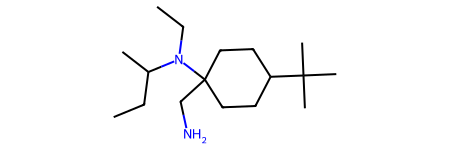

CCC(C)N(CC)C1(CN)CCC(C(C)(C)C)CC1


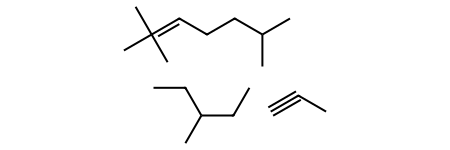

C#CC.CC(C)CCC=C(C)(C)C.CCC(C)CC
19


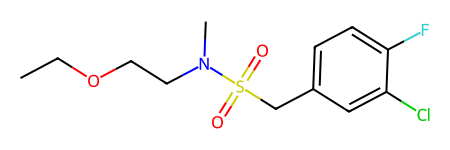

CCOCCN(C)S(=O)(=O)CC1=CC=C(F)C(Cl)=C1


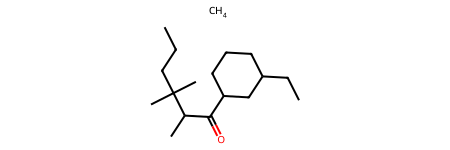

C.CCCC(C)(C)C(C)C(=O)C1CCCC(CC)C1
20


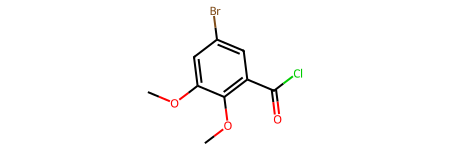

COC1=CC(Br)=CC(C(=O)Cl)=C1OC


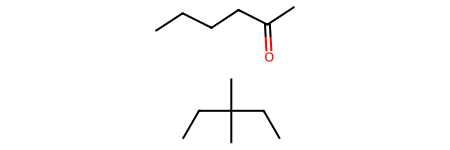

CCC(C)(C)CC.CCCCC(C)=O
21


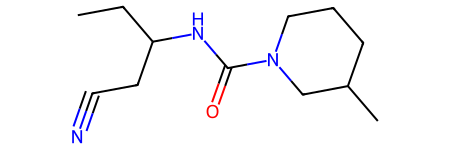

CCC(CC#N)NC(=O)N1CCCC(C)C1


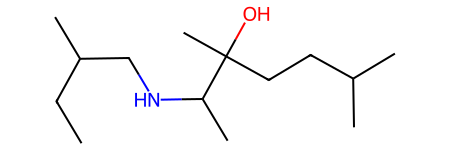

CCC(C)CNC(C)C(C)(O)CCC(C)C
22


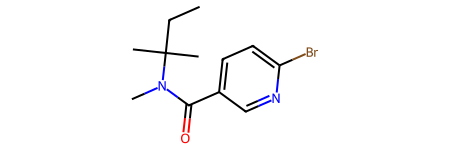

CCC(C)(C)N(C)C(=O)C1=CC=C(Br)N=C1


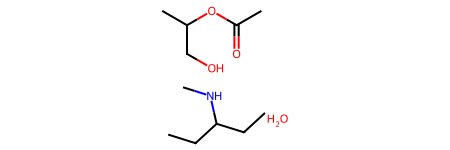

CC(=O)OC(C)CO.CCC(CC)NC.O
23


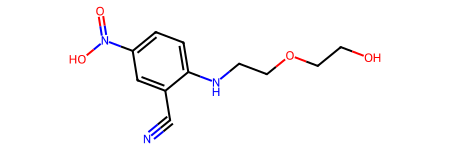

N#CC1=CC(N(=O)O)=CC=C1NCCOCCO


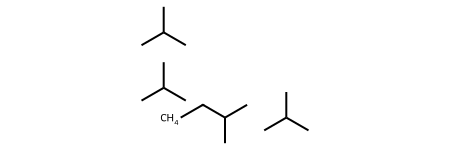

C.CC(C)C.CC(C)C.CC(C)C.CCC(C)C
24


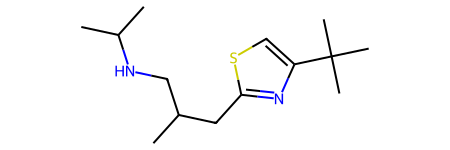

CC(CNC(C)C)CC1=NC(C(C)(C)C)=CS1


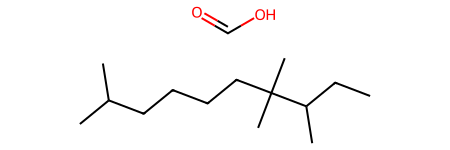

CCC(C)C(C)(C)CCCCC(C)C.O=CO
25


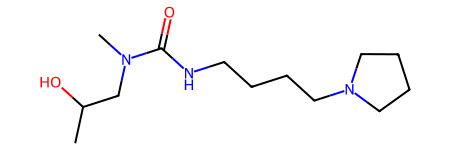

CC(O)CN(C)C(=O)NCCCCN1CCCC1


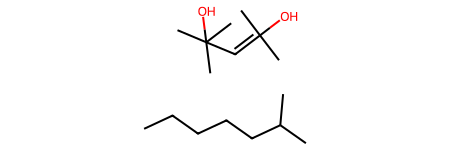

CC(C)(O)=CC(C)(C)(C)O.CCCCCC(C)C
26


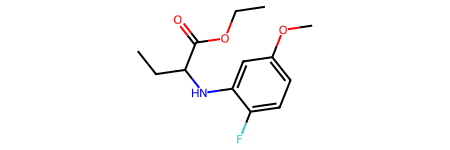

CCOC(=O)C(CC)NC1=CC(OC)=CC=C1F


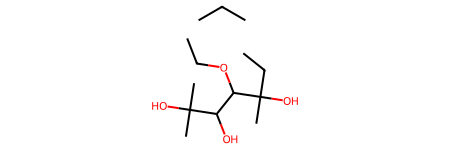

CCC.CCOC(C(O)C(C)(C)O)C(C)(O)CC
27


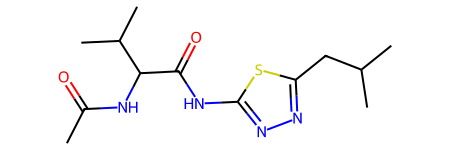

CC(=O)NC(C(=O)NC1=NN=C(CC(C)C)S1)C(C)C


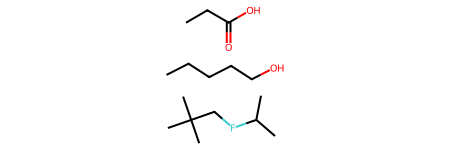

CC(C)FCC(C)(C)C.CCC(=O)O.CCCCCO
28


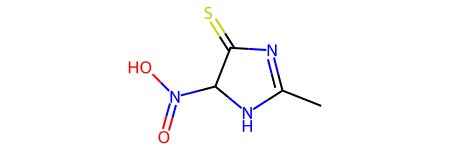

CC1=NC(=S)C(N(=O)O)N1


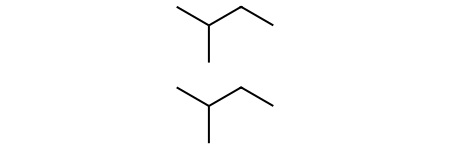

CCC(C)C.CCC(C)C
29


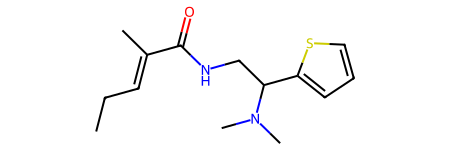

CCC=C(C)C(=O)NCC(C1=CC=CS1)N(C)C


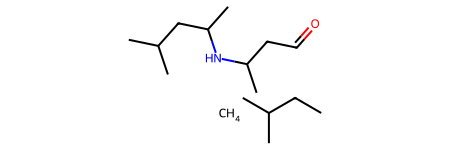

C.CC(C)CC(C)NC(C)CC=O.CCC(C)C
30


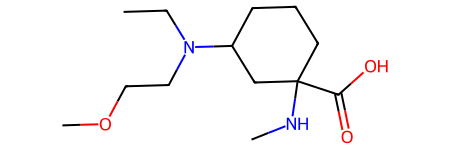

CCN(CCOC)C1CCCC(NC)(C(=O)O)C1


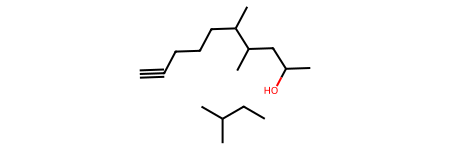

C#CCCCC(C)C(C)CC(C)O.CCC(C)C
31


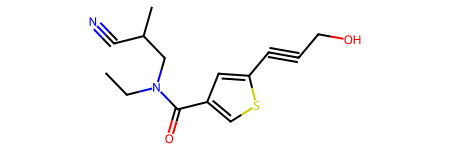

CCN(CC(C)C#N)C(=O)C1=CSC(C#CCO)=C1


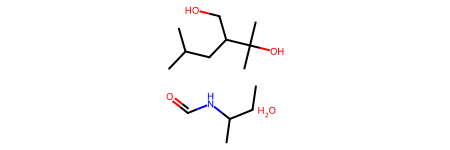

CC(C)CC(CO)C(C)(C)O.CCC(C)NC=O.O


In [17]:
print("%s to %s" % (class_1, class_2))
for i in range(min(32, len(before_1_to_2_mols))):
    print(i)
    IPython.display.display(plot_molecule(before_1_to_2_mols[i]))
    print(rdkit.Chem.MolToSmiles(before_1_to_2_mols[i]))
    IPython.display.display(plot_molecule(after_1_to_2_mols[i]))
    print(rdkit.Chem.MolToSmiles(after_1_to_2_mols[i]))
    
print("%s to %s" % (class_2, class_1))
for i in range(min(32, len(before_2_to_1_mols))):
    print(i)
    IPython.display.display(plot_molecule(before_2_to_1_mols[i]))
    print(rdkit.Chem.MolToSmiles(before_2_to_1_mols[i]))
    IPython.display.display(plot_molecule(after_2_to_1_mols[i]))
    print(rdkit.Chem.MolToSmiles(after_2_to_1_mols[i]))